# Лаборатораня работа №4: Линейные модели, SVM и деревья решений.

### 0) Бибилиотеки, загрузка датасета, кодирование категориальных признаков

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import Image
from IPython.core.display import HTML

In [2]:
df = pd.read_csv('student-mat.csv')

In [4]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

Определим категориальные признаки и закодируем их.

In [6]:
category_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup',
                'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

print('Количество уникальных значений\n')
for col in category_cols:
    print(f'{col}: {df[col].unique().size}')

Количество уникальных значений

school: 2
sex: 2
address: 2
famsize: 2
Pstatus: 2
Mjob: 5
Fjob: 5
reason: 4
guardian: 3
schoolsup: 2
famsup: 2
paid: 2
activities: 2
nursery: 2
higher: 2
internet: 2
romantic: 2


In [7]:
df = pd.get_dummies(df, columns=category_cols)

### 1) Разделение выборки на обучающую и на тестовую

Для начала проведем корреляционный анализ, чтобы выявить признаки, имеющие наибольшее значение для прогнозирования успеваемости.

In [12]:
print('Признаки, имеющие максимальную по модулю корреляцию с итоговой оценкой')
best_params = df.corr()['G3'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.3]
best_params

Признаки, имеющие максимальную по модулю корреляцию с итоговой оценкой


G2          0.904868
G1          0.801468
failures    0.360415
Name: G3, dtype: float64

Признаков вышло мало, поэтому сразу разделим выборки.

In [14]:
y = df['G3']
X = df[best_params.index]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

### 2) Линейная регрессия

In [15]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [16]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred_linear = linear_model.predict(x_test)
print_metrics(y_test, y_pred_linear)

R^2: 0.8526128653441721
MSE: 3.1345447757945313
MAE: 1.127033452596034


### 3) Полиномиальная регрессия

In [17]:
poly_model = PolynomialFeatures(degree=3)
x_train_poly = poly_model.fit_transform(x_train)
x_test_poly = poly_model.fit_transform(x_test)
linear_model = LinearRegression()
linear_model.fit(x_train_poly, y_train)
y_pred_poly = linear_model.predict(x_test_poly)
print_metrics(y_test, y_pred_poly)

R^2: 0.8349290224596059
MSE: 3.510634571279246
MAE: 1.2189500674778215


### 4) SVM

In [18]:
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train_scaled.describe()

,G2,G1,failures
count,2.760000e+02,2.760000e+02,2.760000e+02
mean,2.171170e-16,-2.102535e-16,-2.815783e-18
std,1.001817e+00,1.001817e+00,1.001817e+00
min,-2.939406e+00,-2.364900e+00,-4.517868e-01
25%,-4.735213e-01,-8.671663e-01,-4.517868e-01
50%,7.445303e-02,3.147412e-02,-4.517868e-01
75%,6.224273e-01,6.305677e-01,-4.517868e-01
max,2.266350e+00,2.427849e+00,3.658977e+00


In [19]:
params = {'C': np.concatenate([np.arange(0.1, 2, 0.1), np.arange(2, 15, 1)])}
svm_model = SVR(kernel='linear')
grid_cv = GridSearchCV(estimator=svm_model, param_grid=params, cv=10, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train_scaled, y_train)
print(grid_cv.best_params_)

{'C': 0.30000000000000004}


In [20]:
best_svm_model = grid_cv.best_estimator_
best_svm_model = SVR(kernel='linear', C=14)
best_svm_model.fit(x_train_scaled, y_train)
y_pred_svm = best_svm_model.predict(x_test_scaled)
print_metrics(y_test, y_pred_svm)

R^2: 0.8551794164846249
MSE: 3.079960842889519
MAE: 0.8718718870890911


### 5) Дерево решений

In [21]:
params = {'min_samples_leaf': range(3, 30)}
tree = DecisionTreeRegressor(random_state=3)
grid_cv = GridSearchCV(estimator=tree, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'min_samples_leaf': 4}


In [22]:
best_tree = grid_cv.best_estimator_
best_tree.fit(x_train, y_train)
y_pred_tree = best_tree.predict(x_test)
print_metrics(y_test, y_pred_tree)

R^2: 0.8497812470558482
MSE: 3.1947660042853117
MAE: 1.069561157796452


In [23]:
importances = pd.DataFrame(data=zip(x_train.columns, best_tree.feature_importances_), columns=['Признак', 'Важность'])
print('Важность признаков в дереве решений\n')
for row in importances.sort_values(by='Важность', ascending=False).values:
    print(f'{row[0]}: {round(row[1], 3)}')

Важность признаков в дереве решений

G2: 0.955
G1: 0.031
failures: 0.015


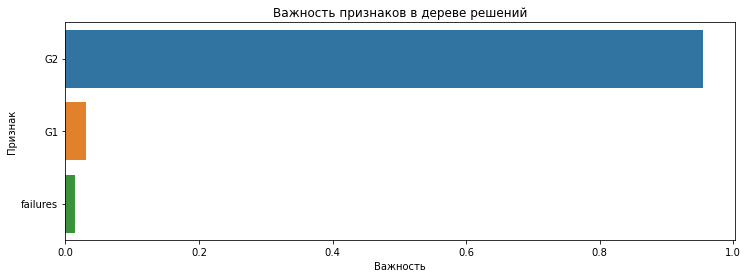

In [24]:
plt.figure(figsize=(12, 4))
sns.barplot(data=importances.sort_values(by='Важность', ascending=False), y='Признак', x='Важность', orient='h', )
plt.title('Важность признаков в дереве решений')
plt.show()

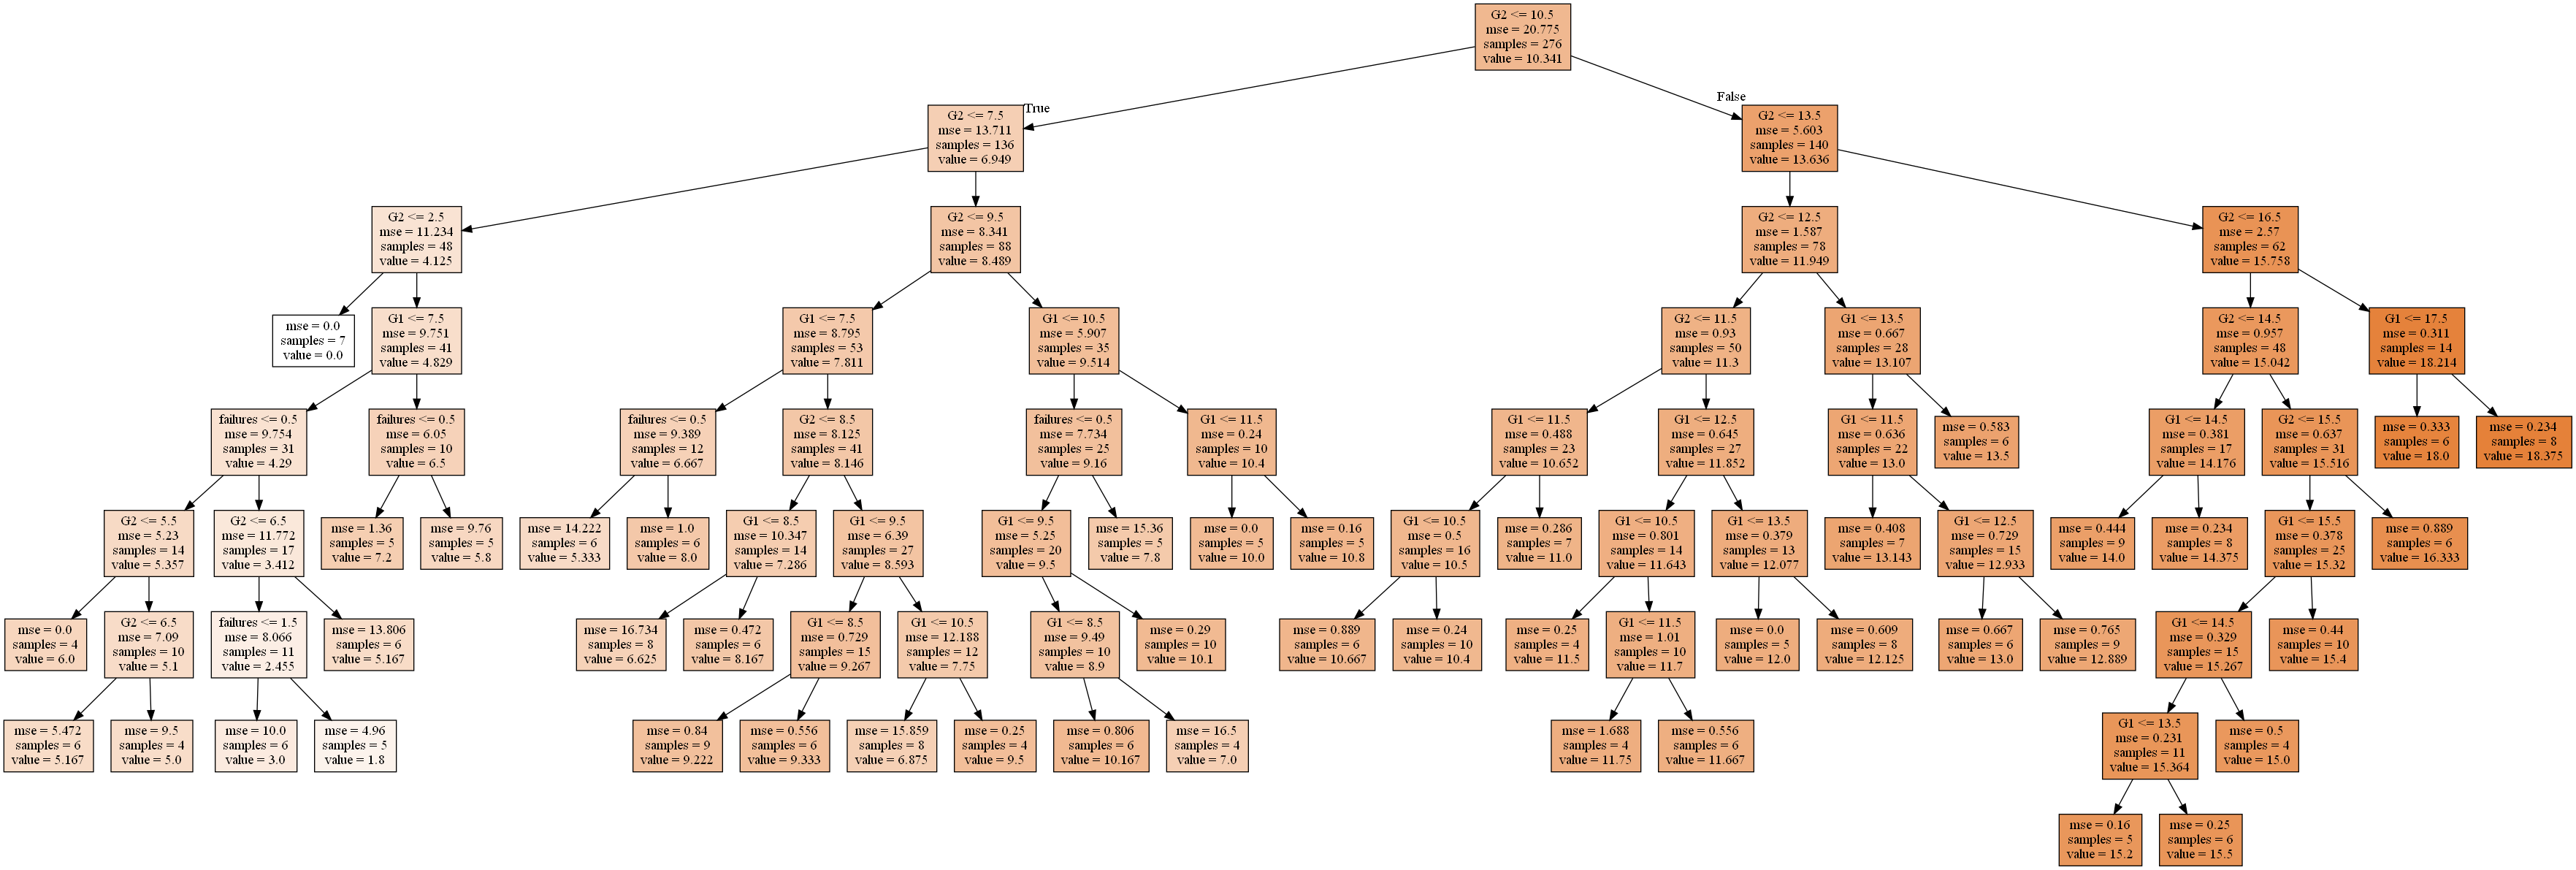

In [29]:
export_graphviz(best_tree, feature_names=best_params.index, filled=True, out_file='tree.dot')
!dot -Tpng tree.dot -o tree.png
Image(filename='tree.png')

### 6) Сравнение моделей

In [27]:
print('Линейная регрессия')
print_metrics(y_test, y_pred_linear)

print('\nПолиномиальная регрессия')
print_metrics(y_test, y_pred_poly)

print('\nМетод опорных векторов')
print_metrics(y_test, y_pred_svm)

print('\nДерево решений')
print_metrics(y_test, y_pred_tree)

Линейная регрессия
R^2: 0.8526128653441721
MSE: 3.1345447757945313
MAE: 1.127033452596034

Полиномиальная регрессия
R^2: 0.8349290224596059
MSE: 3.510634571279246
MAE: 1.2189500674778215

Метод опорных векторов
R^2: 0.8551794164846249
MSE: 3.079960842889519
MAE: 0.8718718870890911

Дерево решений
R^2: 0.8497812470558482
MSE: 3.1947660042853117
MAE: 1.069561157796452
